# Pronostico basado en ESP

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import numpy as np
import calendar
import datetime 

sns.set()

from IPython.display import HTML

In [2]:
# Define the basin level 2 code 
codcuenca_n2 = 61

In [3]:
basin_level3 = pd.read_csv(f'../output_modelo/cuenca_nivel3.csv',usecols=lambda col: col.startswith(str(codcuenca_n2)))
basin_level2 = pd.read_csv(f'../output_modelo/cuenca_nivel2.csv',usecols=lambda col: col.startswith(str(codcuenca_n2)))

In [4]:
# Insert the folder path 
folder_path = '../output_modelo/esp/'
# get a list of all CSV file in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
# Initialize an empty list to store dataframes
df_list = []

# Iterate over the list of files and read each one into a dataframe
for file in file_list:
    # Importar los datos 
    file_path = os.path.join(folder_path,file)
    df = pd.read_csv(file_path,usecols=lambda col: col.startswith((str(codcuenca_n2),'-1')))
    df = df.rename(columns={'-1': 'year','-1.1':'month'})
    df['date'] = pd.to_datetime(dict(year=df['year'],month=df['month'],day=1))
    df = df.set_index('date')
    df['days_in_month'] = df.index.days_in_month
    # Convert into discharge units
    df_selected = df.drop(['year','month','days_in_month'],axis=1)
    discharge = pd.DataFrame(df_selected.values*1000*basin_level3.values,columns=df_selected.columns)
    discharge['days_in_month'] = df['days_in_month'].values
    discharge = discharge.loc[:, discharge.columns != 'days_in_month'].divide(discharge["days_in_month"]*24*3600, axis="index")
    discharge['date'] = df.index.values
    discharge = discharge.set_index('date')
    discharge['year'] = df['year'].values
    discharge['month'] = df['month'].values
    # Aggregate discharge
    aggregate_discharge = pd.DataFrame()
    aggregate_discharge['year'] = discharge['year']
    aggregate_discharge['month'] = discharge['month']
    discharge = discharge.drop(['year','month'],axis=1)
    aggregate_discharge['discharge'] = discharge.sum(axis=1)
    # extract only the forecast
    forecast_rows = aggregate_discharge.iloc[-7:]
    df_list.append(forecast_rows)
    aggregate_discharge = aggregate_discharge.iloc[:-6,:]

concat_df = pd.concat(df_list)

In [5]:
concat_df = concat_df.reset_index()
HTML(concat_df.tail(20).to_html(index=False))

date,year,month,discharge
2023-06-01,2023,6,80.217136
2023-07-01,2023,7,21.912526
2023-08-01,2023,8,29.573345
2023-09-01,2023,9,28.916761
2023-10-01,2023,10,14.574290
2023-11-01,2023,11,6.450604
2023-05-01,2023,5,0.701958
2023-06-01,2023,6,34.520708
2023-07-01,2023,7,35.745631
2023-08-01,2023,8,26.990673


In [6]:
DISCHARGE_SELECTION = aggregate_discharge[(aggregate_discharge['year'] >= 1981) & (aggregate_discharge['year'] <= 2010)]

In [7]:
DISCHARGE_SELECTION

,year,month,discharge
date,,,
1981-01-01,1981,1,14.548094
1981-02-01,1981,2,9.464233
1981-03-01,1981,3,3.556783
1981-04-01,1981,4,1.365688
1981-05-01,1981,5,58.362787
...,...,...,...
2010-08-01,2010,8,98.485704
2010-09-01,2010,9,83.978912
2010-10-01,2010,10,26.131790


In [8]:
percentiles = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).quantile([0.13,0.28,0.72,0.87])
percentiles = percentiles.reset_index()
percentiles = percentiles.drop(columns=['year'])
percentiles.rename(columns={'level_1':'percentile','discharge':'discharge_percentile'}, inplace=True)

In [9]:
percentiles.query('month==5')

,month,percentile,discharge_percentile
16,5,0.13,0.487202
17,5,0.28,4.829971
18,5,0.72,29.089446
19,5,0.87,75.290107


In [10]:
max_values = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).max()
max_values = max_values.drop(columns=['year'])
min_values = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).min()
min_values = min_values.drop(columns=['year'])

In [11]:
min_values.query('month==3')['discharge'].item()

0.0023923905092592596

In [12]:
percentiles['date'] = pd.to_datetime(percentiles['month'],format='%m',errors='coerce')
percentiles['date'] = percentiles['date'].dt.to_period('M').dt.to_timestamp()

In [13]:
# OJO: CAMBIAR LA FECHA
discharge_plot = aggregate_discharge.loc['2022-01-01':'2023-05-01']
discharge_plot = discharge_plot.reset_index()

In [14]:
# create empty columns in the dataframe
discharge_plot['13th_percentile'] = np.nan
discharge_plot['28th_percentile'] = np.nan
discharge_plot['72th_percentile'] = np.nan
discharge_plot['87th_percentile'] = np.nan

for i in range(len(discharge_plot)):
    # Extract the current month 
    m = discharge_plot.month[i]
    discharge_plot.loc[discharge_plot.eval('month==@m'),'minimum']  = percentiles.query('month==@m & percentile==0.13')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'13th_percentile']  = percentiles.query('month==@m & percentile==0.13')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'28th_percentile']  = percentiles.query('month==@m & percentile==0.28')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'72th_percentile']  = percentiles.query('month==@m & percentile==0.72')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'87th_percentile']  = percentiles.query('month==@m & percentile==0.87')['discharge_percentile'].item()

In [15]:
discharge_plot.query('month==5')

,date,year,month,discharge,13th_percentile,28th_percentile,72th_percentile,87th_percentile,minimum
4,2022-05-01,2022,5,0.863228,0.487202,4.829971,29.089446,75.290107,0.487202
16,2023-05-01,2023,5,0.701958,0.487202,4.829971,29.089446,75.290107,0.487202


In [16]:
df_stats = pd.DataFrame(index=pd.date_range(start=discharge_plot['date'].iloc[0], end=concat_df['date'].iloc[-1], freq='MS',inclusive='both'))
df_stats['month'] = df_stats.index.month
df_stats = df_stats.rename_axis('date')


In [17]:
# create empty columns in the dataframe
df_stats['13th_percentile'] = np.nan
df_stats['28th_percentile'] = np.nan
df_stats['72th_percentile'] = np.nan
df_stats['87th_percentile'] = np.nan

for i in range(len(df_stats)):
    # Extract the current month 
    m = df_stats.month[i]
    df_stats.loc[df_stats.eval('month==@m'),'13th_percentile']  = percentiles.query('month==@m & percentile==0.13')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'28th_percentile']  = percentiles.query('month==@m & percentile==0.28')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'72th_percentile']  = percentiles.query('month==@m & percentile==0.72')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'87th_percentile']  = percentiles.query('month==@m & percentile==0.87')['discharge_percentile'].item()

df_stats = df_stats.reset_index()
# df_stats['date'] = df_stats['date'].dt.strftime('%Y-%m-01')

In [18]:
df_stats.query('month==5')

,date,month,13th_percentile,28th_percentile,72th_percentile,87th_percentile
4,2022-05-01,5,0.487202,4.829971,29.089446,75.290107
16,2023-05-01,5,0.487202,4.829971,29.089446,75.290107


In [19]:
concat_df['group'] = concat_df.index // 7

In [20]:
discharge_max_plot = max(concat_df['discharge'].max(),discharge_plot['discharge'].max())
discharge_max_plot = round(discharge_max_plot/100)*100

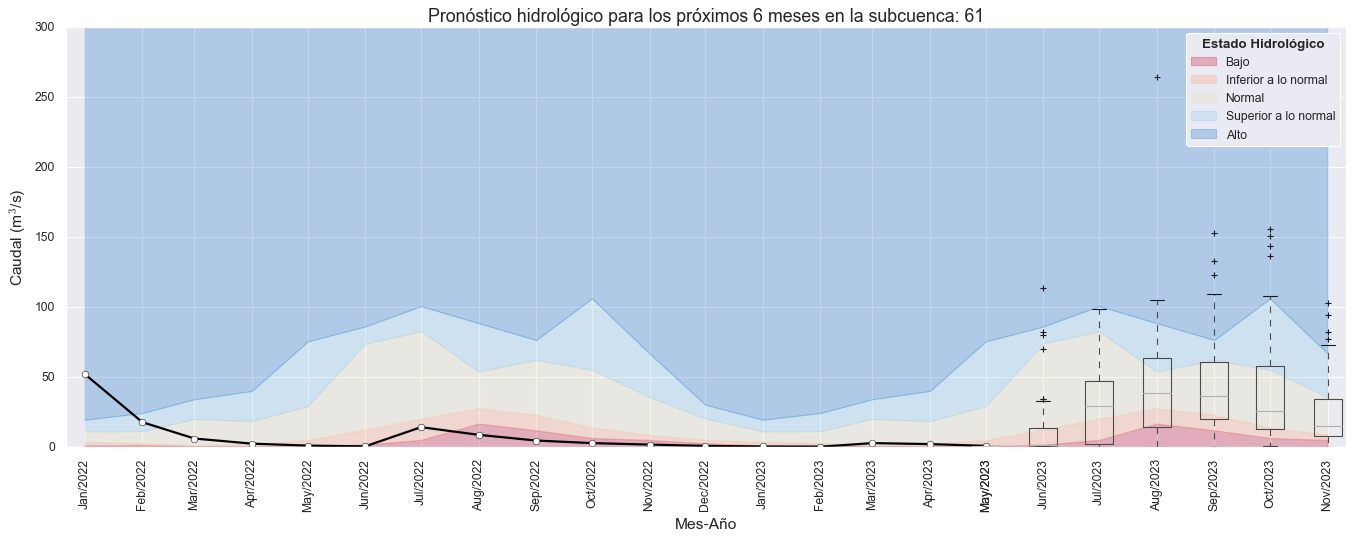

In [21]:
## Get the earliest date in BOTH plots combined
begin=pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).min()

## Add columns linepos and boxpos to the dataframes to show offset from earliest date
discharge_plot['linepos']=(discharge_plot['date']-begin).dt.days
concat_df['boxpos']=(concat_df['date']-begin).dt.days
df_stats['linepos'] = (df_stats['date']-begin).dt.days

## Plot plots - note I am using boxpos and linepos, not dates for x-axis
ax=concat_df[['discharge', 'boxpos']].boxplot(by='boxpos', widths=15, positions=concat_df.boxpos.unique(),figsize=(20,7))
ax.plot(discharge_plot['linepos'], discharge_plot['discharge'], label='_nolegend_',color = 'black',linewidth=2,marker='o', mfc='white', mec='k')
ax.fill_between(df_stats['linepos'], 0, df_stats['13th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax.fill_between(df_stats['linepos'], df_stats['13th_percentile'], df_stats['28th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax.fill_between(df_stats['linepos'], df_stats['28th_percentile'], df_stats['72th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax.fill_between(df_stats['linepos'], df_stats['72th_percentile'], df_stats['87th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax.fill_between(df_stats['linepos'], df_stats['87th_percentile'], discharge_max_plot,color='#2C7DCD', alpha=0.3,label="Alto")

## Set x-lim to include both line and boxes
ax.set_xlim([ min(concat_df.boxpos.min(), discharge_plot.linepos.min())-10, max(concat_df.boxpos.max(), discharge_plot.linepos.max()) + 10 ] )

## To change the x-axis ticks, get the list of all x-entries and sort
locs=(list(concat_df.boxpos.unique())+list(discharge_plot.linepos.unique()))
locs.sort()
ax.set_xticks(locs)
ax.set_ylim(0,discharge_max_plot)

## To add labels get unique dates, sort them, convert to format you like and plot
ax.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )

## Set x and y labels
ax.set_xlabel('Mes-Año',fontsize=14);
ax.set_title(f'Pronóstico hidrológico para los próximos 6 meses en la subcuenca: {codcuenca_n2}',fontsize=16)
ax.set_ylabel('Caudal (m$^3$/s)',fontsize=14);
ax.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})

plt.suptitle('');



In [22]:
discharge_max_plot

300

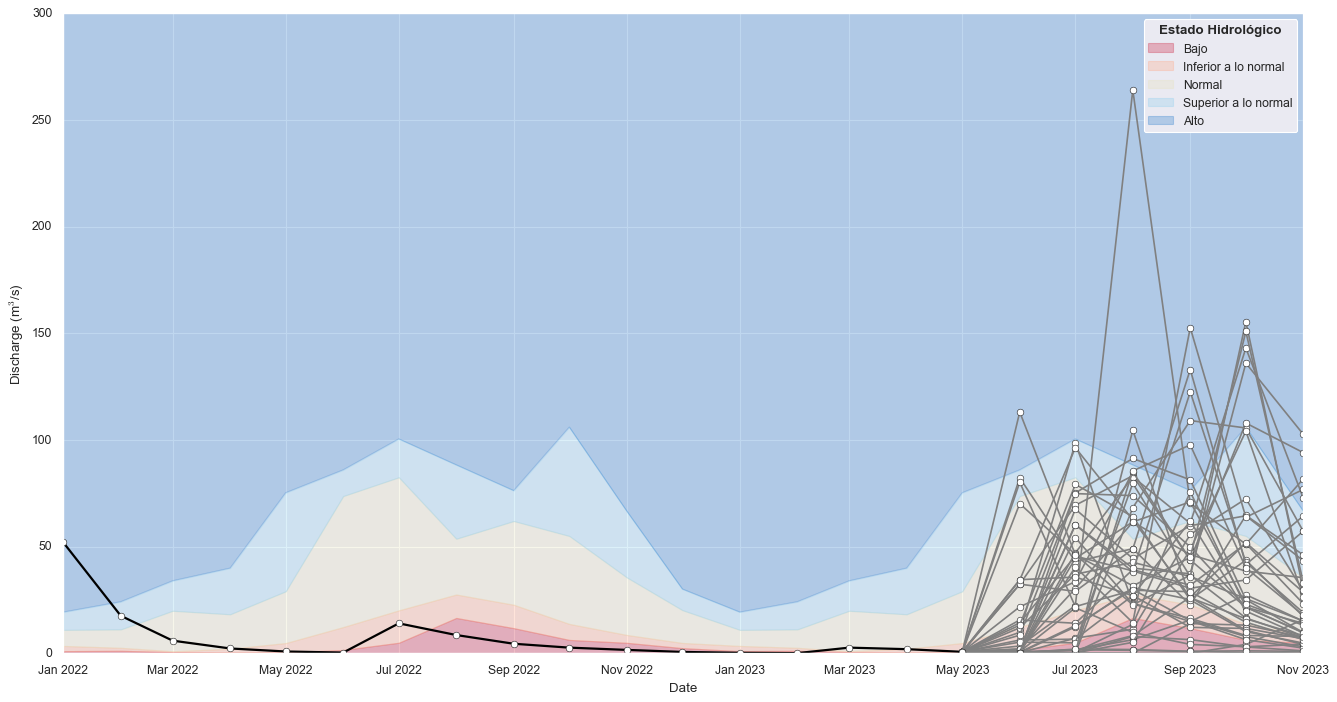

In [24]:
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(discharge_plot['date'],discharge_plot['discharge'],color = 'black',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');
for group,data in concat_df.groupby('group'):
    ax2.plot(data['date'],data['discharge'],color = 'gray',linewidth=1.5,marker='o', mfc='white', mec='k', label='_nolegend_')
ax2.set_xlabel('Date');
## To add labels get unique dates, sort them, convert to format you like and plot
# ax2.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )
ax2.fill_between(df_stats['date'], 0, df_stats['13th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax2.fill_between(df_stats['date'], df_stats['13th_percentile'], df_stats['28th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax2.fill_between(df_stats['date'], df_stats['28th_percentile'], df_stats['72th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax2.fill_between(df_stats['date'], df_stats['72th_percentile'], df_stats['87th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax2.fill_between(df_stats['date'], df_stats['87th_percentile'], 600,color='#2C7DCD', alpha=0.3,label="Alto")
ax2.set_ylim(0,discharge_max_plot)
ax2.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})
ax2.set_ylabel('Discharge (m$^3$/s)');

In [25]:
concat_df

,date,year,month,discharge,group,boxpos
0,2023-05-01,2023,5,0.701958,0,485
1,2023-06-01,2023,6,14.341926,0,516
2,2023-07-01,2023,7,45.569834,0,546
3,2023-08-01,2023,8,38.631347,0,577
4,2023-09-01,2023,9,30.520183,0,608
...,...,...,...,...,...,...
296,2023-07-01,2023,7,1.980490,42,546
297,2023-08-01,2023,8,1.778183,42,577
298,2023-09-01,2023,9,0.962225,42,608
299,2023-10-01,2023,10,1.180078,42,638


In [26]:
concat_df['percentile_range'] = ''
concat_df['percentile_range_summary'] = ''
values_months = ['Low Flow','Below Normal','Normal Range','Above Normal','High Flow']
values_months_summary = ['Low','Normal','High']

for i in range(len(concat_df)):
    # Extract the current month 
    m = concat_df.month[i]
    y = concat_df.year[i]
    # pmin = min_values.query('month==@m')['discharge'].item()
    pmin = 0
    p87 = percentiles.query('percentile == 0.87 & month==@m')['discharge_percentile'].item()
    p72 = percentiles.query('percentile == 0.72 & month==@m')['discharge_percentile'].item()
    p28 = percentiles.query('percentile == 0.28 & month==@m')['discharge_percentile'].item()
    p13 = percentiles.query('percentile == 0.13 & month==@m')['discharge_percentile'].item()
    pmax = max_values.query('month==@m')['discharge'].item()
    value = concat_df.discharge[i]
    category = pd.cut([value],bins=[pmin,p13,p28,p72,p87,pmax],labels=values_months)
    category_summary = pd.cut([value],bins=[pmin,p28,p72,pmax],labels=values_months_summary)
    concat_df.loc[concat_df.eval('index==@i'),'percentile_range'] = category[0]
    concat_df.loc[concat_df.eval('index==@i'),'percentile_range_summary'] = category_summary[0]

In [27]:
# OJO: SELECT FORECAST LEADTIME 
forecast_leadtime = 3
month_outlook = discharge_plot['month'].iloc[-1] + forecast_leadtime

In [28]:
category_counts = concat_df.query('month==@month_outlook')['percentile_range'].value_counts()
category_counts = category_counts.to_frame()
category_counts = category_counts.sort_index(key=lambda x: x.map({val:idx for idx,val in enumerate(values_months)}))

In [29]:
display(category_counts)

,percentile_range
Low Flow,12
Below Normal,5
Normal Range,12
Above Normal,11
High Flow,3


In [30]:
category_counts_summary = concat_df.query('month==@month_outlook')['percentile_range_summary'].value_counts()
category_counts_summary = category_counts_summary.to_frame()
category_counts_summary = category_counts_summary.sort_index(key=lambda x: x.map({val:idx for idx,val in enumerate(values_months_summary)}))

In [31]:
display(category_counts_summary)

,percentile_range_summary
Low,17
Normal,12
High,14


In [32]:
category_counts['percentage_ensemble'] = round((category_counts['percentile_range']/category_counts['percentile_range'].sum())*100,1)
category_counts_summary['percentage_ensemble'] = round((category_counts_summary['percentile_range_summary']/category_counts_summary['percentile_range_summary'].sum())*100,1)

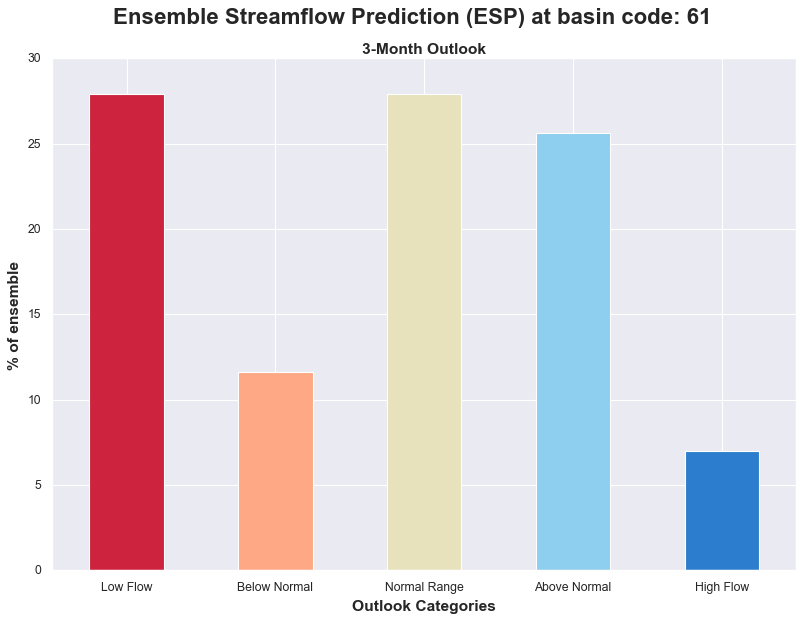

In [33]:
import matplotlib.colors as mcolors
color_mapping = {
    'Low Flow':'#CD233F',
    'Below Normal': '#FFA885',
    'Normal Range': '#E7E2BC',
    'Above Normal': '#8ECEEE',
    'High Flow': '#2C7DCD'
}

column_name = category_counts.index.to_list()
colors = [mcolors.to_rgb(color_mapping.get(x,'#808080')) for x in category_counts.index]
ax3 = category_counts['percentage_ensemble'].plot(kind='bar',color=colors,figsize=(12, 8));
plt.xticks(range(len(category_counts.index)),column_name,rotation=0,horizontalalignment='center');
plt.xlabel('Outlook Categories',fontweight='bold',fontsize=14);
plt.ylabel('% of ensemble',fontweight='bold',fontsize=14);
plt.suptitle(f'Ensemble Streamflow Prediction (ESP) at basin code: {codcuenca_n2}',fontweight='bold',fontsize=20);
plt.title(f"{forecast_leadtime}-Month Outlook",fontweight='bold',fontsize=14);

In [34]:
display(category_counts)

,percentile_range,percentage_ensemble
Low Flow,12,27.9
Below Normal,5,11.6
Normal Range,12,27.9
Above Normal,11,25.6
High Flow,3,7.0


In [35]:
display(category_counts_summary)

,percentile_range_summary,percentage_ensemble
Low,17,39.5
Normal,12,27.9
High,14,32.6


In [36]:
column_name_sum_espanol = ['Bajo','Normal','Alto']

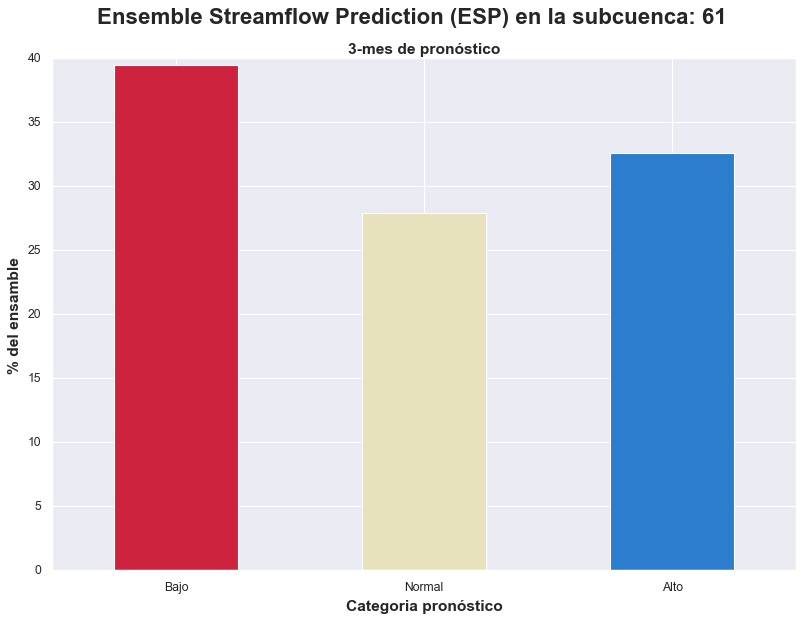

In [37]:
color_mapping_summary = {
    'Low':'#CD233F',
    'Normal': '#E7E2BC',
    'High': '#2C7DCD'
}

column_name_sum = category_counts_summary.index.to_list()
colors_sum = [mcolors.to_rgb(color_mapping_summary.get(y,'#808080')) for y in category_counts_summary.index]
ax4 = category_counts_summary['percentage_ensemble'].plot(kind='bar',color=colors_sum,figsize=(12, 8));
plt.xticks(range(len(category_counts_summary.index)),column_name_sum_espanol,rotation=0,horizontalalignment='center');
# plt.xticks(range(len(category_counts_summary.index)),column_name_sum,rotation=0,horizontalalignment='center');
plt.xlabel('Categoria pronóstico',fontweight='bold',fontsize=14);
plt.ylabel('% del ensamble',fontweight='bold',fontsize=14);
plt.suptitle(f'Ensemble Streamflow Prediction (ESP) en la subcuenca: {codcuenca_n2}',fontweight='bold',fontsize=20);
plt.title(f"{forecast_leadtime}-mes de pronóstico",fontweight='bold',fontsize=14);
